# eCommerce Product Recommendation - Part 1
We analyze the anonymous data of the instacart e-commerce platform to predict whether users will repurchase products and make recommendations.



# 0. Load Raw Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict 

In [24]:
aisles = pd.read_csv('aisles.csv') 
departments = pd.read_csv('departments.csv') 
order_products_prior = pd.read_csv('order_products_prior.csv') 
order_products_train = pd.read_csv('order_products_train.csv') 
orders = pd.read_csv('orders.csv') 
products = pd.read_csv('products.csv') 

In [25]:
print(aisles.shape)
print(departments.shape)
print(order_products_prior.shape)
print(order_products_train.shape)
print(orders.shape)
print(products.shape)

(134, 2)
(21, 2)
(793924, 4)
(53704, 4)
(82683, 7)
(49688, 4)


In [26]:
aisles.head() 
# aisle_id: aisle identifier
# aisle: the name of the aisle

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [27]:
departments.head() 
# department_id: department identifier
# department: the name of the department

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [28]:
orders.head() 
# eval_set: which evaluation set this order belongs in (see SET described below)
# order_number: the order sequence number for this user (1 = first, n = nth)
# order_dow: the day of the week the order was placed on
# order_hour_of_day: the hour of the day the order was placed on
# days_since_prior: days since the last order, capped at 30 (with NANs for order_number = 1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [29]:
products.head()
# product_id: product identifier
# product_name: name of the product
# aisle_id: foreign key
# department_id: foreign key

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [30]:
order_products_prior.head() 
# reordered: 1 if this product has been ordered by this user in the past, 0 otherwise
# "prior": orders prior to that users most recent order 

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [31]:
order_products_train.head()
# "train": training data supplied to participants 

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


# 1. Data Exploration

1.1 Build prior order details table for data exploration

In [32]:
prior_order_details = order_products_prior.merge(orders, on="order_id")
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


Covert dow(day of the week) to string for better visualization

In [33]:

prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Sunday" if x==0 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Monday" if x==1 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Tuesday" if x==2 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Wednesday" if x==3 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Thursday" if x==4 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Friday" if x==5 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Saturday" if x==6 else x)

In [34]:
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0
1,12,15221,2,1,152610,prior,22,Saturday,8,10.0
2,12,43772,3,1,152610,prior,22,Saturday,8,10.0
3,12,37886,4,1,152610,prior,22,Saturday,8,10.0
4,12,37215,5,0,152610,prior,22,Saturday,8,10.0


1.2 Visualize order frequency on DoW

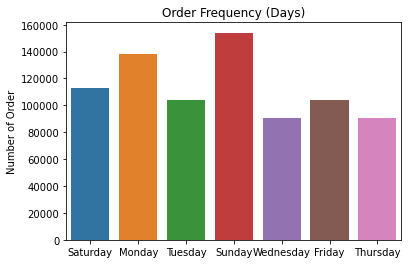

In [35]:
# Frequency of Order Based on Days 
ax = sns.countplot(x="order_dow",data=prior_order_details)
plt.title("Order Frequency (Days)")
plt.xlabel("")
plt.ylabel("Number of Order")
plt.show()

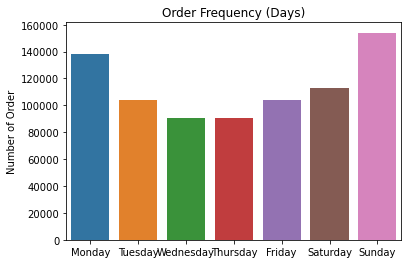

In [36]:
#Frequency of Order Based on Days 
ax = sns.countplot(x="order_dow",data=prior_order_details,
                   order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Order Frequency (Days)")
plt.xlabel("")
plt.ylabel("Number of Order")
plt.show()

1.3 Visualize order frequency on HoD

C:\Users\86186\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


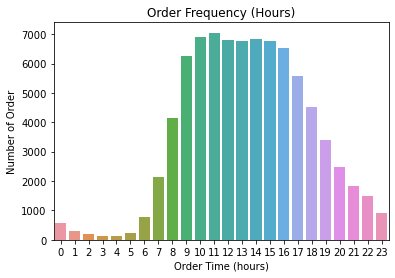

In [37]:
order_hours_counts = orders.groupby("order_id")["order_hour_of_day"].mean().reset_index()  # to avoid abnormal situations
order_hod_stats = order_hours_counts.order_hour_of_day.value_counts()
sns.barplot(order_hod_stats.index, order_hod_stats.values)
plt.title("Order Frequency (Hours)")
plt.ylabel("Number of Order")
plt.xlabel('Order Time (hours)')
plt.show()

1.4 Reorder Pattern Analysis

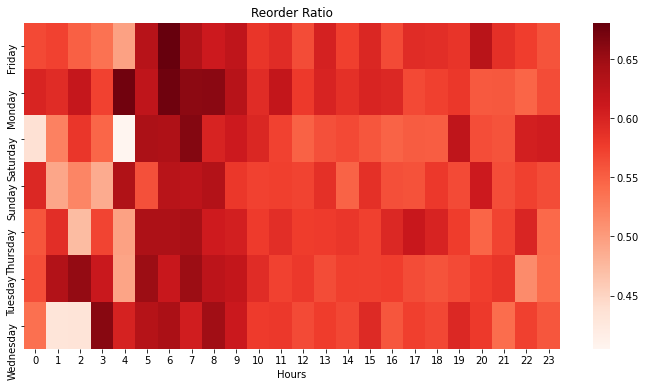

In [38]:
reorder_heatmap = prior_order_details.groupby(["order_dow", "order_hour_of_day"])["reordered"].mean().reset_index()
reorder_heatmap = reorder_heatmap.pivot('order_dow', 'order_hour_of_day', 'reordered')
plt.figure(figsize=(12,6))
sns.heatmap(reorder_heatmap,cmap="Reds")
plt.title("Reorder Ratio")
plt.ylabel("")
plt.xlabel("Hours")
plt.show()

# 2. Data Quality Check

2.1. Validate the `days_since_prior_order` column in orders table

In [39]:
orders.head() 
# days since the last order (with NAs for order_number = 1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [40]:
print("Size of the order dataset: ", orders.shape[0])
print("NaN count in days_since_prior_order column: ", orders[orders.days_since_prior_order.isnull()].shape[0]) 
print("order_number 1 count in orders table: ", orders[orders.order_number == 1].drop_duplicates().shape[0]) 
print("user_id count in orders table: ", orders.user_id.drop_duplicates().shape[0]) 

Size of the order dataset:  82683
NaN count in days_since_prior_order column:  5000
order_number 1 count in orders table:  5000
user_id count in orders table:  5000


So in the orders.csv，the number of rows with "days_since_prior_order == NaN" is equal to the number of rows with "order_number == 1"，which is also the number of users. 

2.2.Validate Valid orders matching in the prior table. 

In [41]:
orders.groupby(['eval_set']).agg(OrderedDict([('order_id','nunique')])).reset_index()

,eval_set,order_id
0,prior,77683
1,train,5000


Make sure the order_id in order_products_prior.csv are all in the order.csv. 

In [42]:
print("order_id count in prior: ", order_products_prior['order_id'].nunique())
print("order_id from prior found in orders: ", order_products_prior[order_products_prior.order_id.isin(orders.order_id)].order_id.nunique())

order_id count in prior:  77683
order_id from prior found in orders:  77683


2.3. Validate orders matching in the train table

In [43]:
print("orders count in train: ", order_products_train['order_id'].nunique())

orders count in train:  5000


In [44]:
order_products_train.order_id.nunique()

5000

In [45]:
print("order_id from train found in orders: ", order_products_train[order_products_train.order_id.isin(orders.order_id)].order_id.nunique())

order_id from train found in orders:  5000


2.4. Validate the intersection between prior and train table

In [46]:
print("order_id intersection between prior and train: ", pd.merge(order_products_prior, order_products_train, on = ['order_id']).shape[0])

order_id intersection between prior and train:  0


2.5. Validate the user_id matching in prior and train set

In [47]:
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('user_id','nunique')]))

,eval_set,user_id
0,prior,5000
1,train,5000


In [48]:
prior_user_ids = set(orders[orders['eval_set'] == 'prior']['user_id'])
train_user_ids = set(orders[orders['eval_set'] == 'train']['user_id']) 
print("user_ids in prior: ", len(prior_user_ids))
print("user_ids in train: ", len(train_user_ids))
print("intersection of prior and train: ", len(prior_user_ids.intersection(train_user_ids)))

user_ids in prior:  5000
user_ids in train:  5000
intersection of prior and train:  5000


2.6. Validate order counts in the train dataset

In [49]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [50]:
(orders[orders['eval_set'] == 'train'] 
  .groupby(['user_id'], as_index = False)         
  .agg(OrderedDict([('order_number','count')]))
  .rename(columns={'order_number':'order_counts'})                
  .sort_values(by=['order_counts'], ascending=False)).head() 

,user_id,order_counts
0,50,1
3330,135574,1
3337,135956,1
3336,135881,1
3335,135743,1


Therefore, every user only has one order in the train dataset.

2.7. Validate the relative order of `order_num` in prior and train dataset

We want to verify that all the order_num's in prior dataset are strictly smaller than all the order_num's in the train dataset. All we have to do is to compare the minimum of order_num in the prior dataset and the maximum of order_num in the train dataset.

In [51]:
df_prior_order_max = (orders[orders.user_id.isin(prior_user_ids)][orders.eval_set == 'prior']
  .groupby(['user_id'], as_index=False)
  .agg(OrderedDict([('order_number','max')]))
  .rename(columns={'order_number':'prior_order_max'}))

In [52]:
df_train_order_min = (orders[orders.user_id.isin(train_user_ids)][orders.eval_set == 'train']
  .groupby(['user_id'], as_index=False)
  .agg(OrderedDict([('order_number','min')]))
  .rename(columns={'order_number':'train_order_min'}))

In [53]:
df_order_diff = pd.merge(df_prior_order_max, df_train_order_min, on = ['user_id'])
print("Rows count where prior_order_max >= train_order_min: ", 
      df_order_diff[df_order_diff.prior_order_max >= df_order_diff.train_order_min].shape[0])

Rows count where prior_order_max >= train_order_min:  0
